In [1]:
import pandas as pd
import os
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

from Constants import Constants as const

In [2]:
# Step 1: Load the data and create event time variable
file_path = os.path.join(const.RESULT_PATH, '20241014_stock_act_reg_data_v2.dta')
data = pd.read_stata(file_path).copy()

# Generate the event time variable
data['time_event'] = data['fiscal_year'] - 2012

# Step 2: Create dummies for each event time from -4 to +3
for i in range(0, 4):
    data.loc[:, f'event_{i}'] = (data['time_event'] == i).astype(int)
    data.loc[:, f'event_b{i+1}'] = (data['time_event'] == -i - 1).astype(int)


/tmp/ipykernel_170246/2186004549.py:3: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.
  data = pd.read_stata(file_path)
/tmp/ipykernel_170246/2186004549.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['time_event'] = data['fiscal_year'] - 2012
/tmp/ipykernel_170246/2186004549.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-f

In [11]:
# Step 3: Run the regression excluding the base year (event_-1)
# Specify interaction terms with ':' and use C() for categorical variables
interaction_terms = [f"event_b{i} * MajorGovCustomer" for i in [3, 2, 1]]
interaction_terms.extend([f"event_{i} * MajorGovCustomer" for i in [0, 1, 2, 3]])

# Define the formula correctly with interaction terms
formula = "log_frequency_w ~ " + " + ".join(interaction_terms) + \
    " + log_market_value_w + lev_w + BM_w + ROA_w + LOSS + EarnVol_w + ret_w + turnover_w + StkVol_w + C(gvkey) + C(year)"

# Fit the model with clustered standard errors at the gvkey level
reg_data = data
model = smf.ols(formula, reg_data).fit(cov_type='cluster', cov_kwds={'groups': reg_data['gvkey']})

# Extract coefficients for the event study
coeff_names = [f'event_b{i}:MajorGovCustomer' for i in [3, 2, 1]]
coeff_names.extend([f'event_{i}:MajorGovCustomer' for i in [0, 1, 2, 3]])
coeffs = model.params[coeff_names]
conf_int = model.conf_int(alpha=0.05).loc[coeff_names]

In [6]:
# insert one point to this position
position = 3
coeffs1 = coeffs.iloc[:position]
coeffs2 = coeffs.iloc[position:]

new_coeffs = pd.Series([np.nan], index=[position])

coeffs = pd.concat([coeffs1, new_coeffs, coeffs2]).reset_index(drop=True)

conf_int1 = conf_int.iloc[:position]
conf_int2 = conf_int.iloc[position:]
conf_int1.loc[position] = {0: np.nan, 1: np.nan}
conf_int = pd.concat([conf_int1, conf_int2]).reset_index(drop=True)

/tmp/ipykernel_170246/2125390330.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conf_int1.loc[position] = {0: np.nan, 1: np.nan}


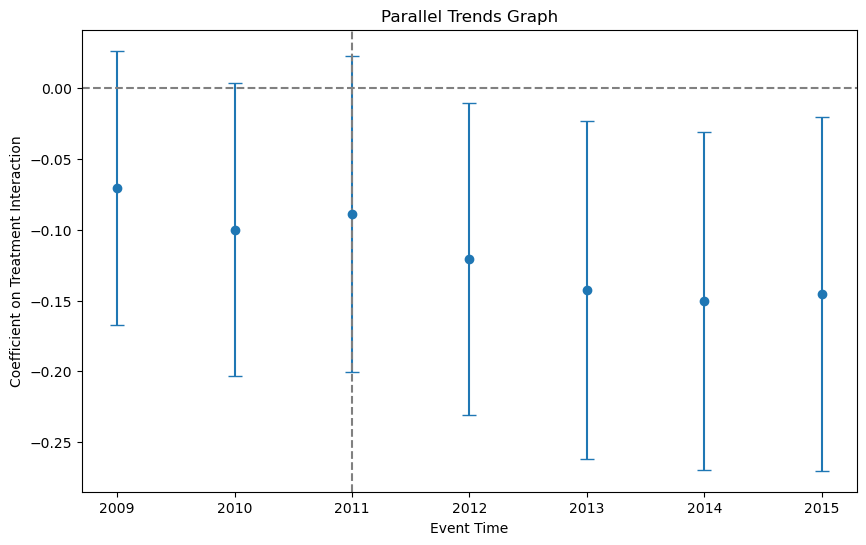

In [12]:
plt.show()
pic_save_path = os.path.join(const.REGRESSION_RESULT_PATH, '20241101')
if not os.path.isdir(pic_save_path):
    os.mkdir(pic_save_path)

# Step 4: Plot the parallel trends graph
year_labels = { -4: "2008", -3: "2009", -2: "2010", -1: "2011", 
                 0: "2012",  1: "2013",  2: "2014",  3: "2015"}

plt.figure(figsize=(10, 6))
plt.errorbar(x=range(-3, 4), y=coeffs,
             yerr=[coeffs - conf_int[0], conf_int[1] - coeffs], fmt='o', capsize=5)

plt.axhline(0, color='grey', linestyle='--')
plt.axvline(-1, color='grey', linestyle='--')
plt.xlabel("Event Time")
plt.ylabel("Coefficient on Treatment Interaction")
plt.title("Parallel Trends Graph")
plt.xticks(ticks=range(-3, 4), labels=[year_labels[year] for year in [-3, -2, -1, 0, 1, 2, 3]])
plt.savefig(os.path.join(pic_save_path, 'parallel_trends_graph.png'))
plt.show()

In [24]:
# Step 3: Run the regression excluding the base year (event_-1)
# Specify interaction terms with ':' and use C() for categorical variables
interaction_terms = [f"event_b{i} * MajorGovCustomer" for i in [3, 2, 1]]
interaction_terms.extend([f"event_{i} * MajorGovCustomer" for i in [0, 1, 2, 3]])

# Define the formula correctly with interaction terms
formula = "log_frequency_w ~ " + " + ".join(interaction_terms) + \
    " + log_market_value_w + lev_w + BM_w + ROA_w + LOSS + EarnVol_w + ret_w + turnover_w + StkVol_w + C(gvkey) + C(year)"

# Fit the model with clustered standard errors at the gvkey level
model = smf.ols(formula, data).fit(cov_type='cluster', cov_kwds={'groups': data['gvkey']})

# Extract coefficients for the event study
coeff_names = [f'event_b{i}:MajorGovCustomer' for i in [3, 2, 1]]
coeff_names.extend([f'event_{i}:MajorGovCustomer' for i in [0, 1, 2, 3]])
coeffs = model.params[coeff_names]
conf_int = model.conf_int().loc[coeff_names]

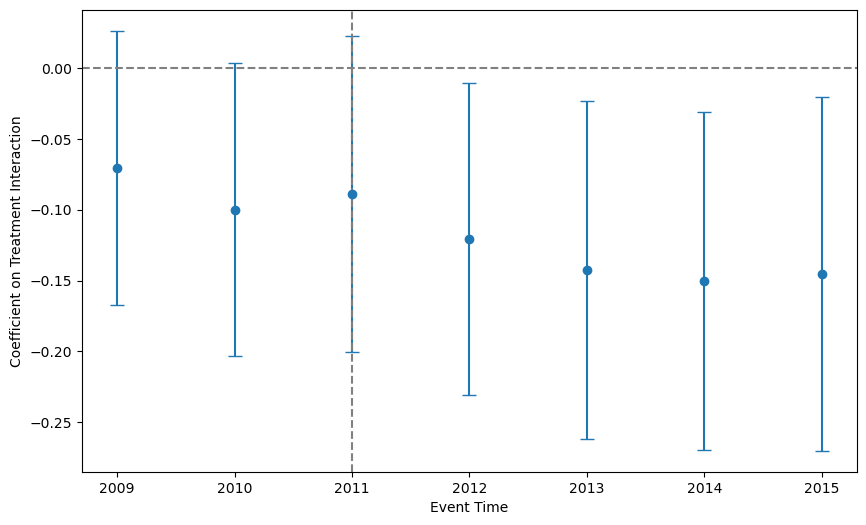

In [28]:
# Step 4: Plot the parallel trends graph
year_labels = { -4: "2008", -3: "2009", -2: "2010", -1: "2011", 
                 0: "2012",  1: "2013",  2: "2014",  3: "2015"}

plt.figure(figsize=(10, 6))
plt.errorbar(x=range(-3, 4), y=coeffs, 
             yerr=[coeffs - conf_int[0], conf_int[1] - coeffs], fmt='o', capsize=5)

plt.axhline(0, color='grey', linestyle='--')
plt.axvline(-1, color='grey', linestyle='--')
plt.xlabel("Event Time")
plt.ylabel("Coefficient on Treatment Interaction")
# plt.title("Parallel Trends Graph")
plt.xticks(ticks=range(-3, 4), labels=[year_labels[year] for year in [-3, -2, -1, 0, 1, 2, 3]])
pic_save_path = r"D:\Users\wangy\Documents\temp\parallel_trending"
if not os.path.isdir(pic_save_path):
    os.mkdir(pic_save_path)
    
plt.savefig(os.path.join(pic_save_path, 'parallel_trends_graph.png')) 
plt.show()

In [ ]:
pic_save_path = r"D:\Users\wangy\Documents\temp\parallel_trending"
if not os.path.isdir(pic_save_path):
    os.mkdir(pic_save_path)
    
plt.savefig(os.path.join(pic_save_path, 'parallel_trends_graph.png'))  # Save as PNG, can also use .pdf, .svg, etc.


In [7]:
# Try the combinations of control variables to get the best regression results.

dep_vars = 'cpie_gpin cpie_owr SYNCHRONICITY_MONTH SYNCHRONICITY_MKT_MONTH SYNCHRONICITY_IND_MONTH numest_last FCSTERROR_last DISPERSION_last'.split(' ')

control_vars = ['log_market_value_w', 'lev_w', 'BM_w', 'ROA_w', 'LOSS', 'EarnVol_w', 'ret_w', 'turnover_w', 'StkVol_w']

pic_save_path = os.path.join(const.REGRESSION_RESULT_PATH, '20241012')


# Iterate over all possible lengths of combinations (1 to len(variables))
for dep in dep_vars:
    tmp_data = data.dropna(subset=[dep])
        
    # Step 3: Run the regression excluding the base year (event_-1)
    # Specify interaction terms with ':' and use C() for categorical variables
    interaction_terms = [f"event_b{i} * MajorGovCustomer" for i in [3, 2]]
    interaction_terms.extend([f"event_{i} * MajorGovCustomer" for i in [0, 1, 2, 3]])
    
    if dep == 'DISPERSION_last':
        control_vars.append('numest_last')
        
    # Define the formula correctly with interaction terms
    formula = f"{dep} ~ " + " + ".join(interaction_terms) + " + " + \
        " + ".join(control_vars) + " + C(gvkey) + C(year)"
    # formula = f"{dep} ~ " + " + ".join(interaction_terms) + " + C(gvkey) + C(year)"
    
    # Fit the model with clustered standard errors at the gvkey level
    model = smf.ols(formula, tmp_data).fit(cov_type='cluster', cov_kwds={'groups': tmp_data['gvkey']})
    
    # Extract coefficients for the event study
    coeff_names = [f'event_b{i}:MajorGovCustomer' for i in [3, 2]]
    coeff_names.extend([f'event_{i}:MajorGovCustomer' for i in [0, 1, 2, 3]])
    coeffs = model.params[coeff_names]
    conf_int = model.conf_int(alpha=0.1).loc[coeff_names]
    
    # insert one point to this position
    position = 2
    coeffs1 = coeffs.iloc[:position]
    coeffs2 = coeffs.iloc[position:]
    
    new_coeffs = pd.Series([np.nan], index=[position])
    
    coeffs = pd.concat([coeffs1, new_coeffs, coeffs2]).reset_index(drop=True)
    
    conf_int1 = conf_int.iloc[:position]
    conf_int2 = conf_int.iloc[position:]
    conf_int1.loc['event_b1:MajorGovCustomer'] = {0: np.nan, 1: np.nan}
    conf_int = pd.concat([conf_int1, conf_int2]).reset_index(drop=True)
    
    # Step 4: Plot the parallel trends graph
    year_labels = { -4: "2008", -3: "2009", -2: "2010", -1: "2011", 
                     0: "2012",  1: "2013",  2: "2014",  3: "2015"}
    
    plt.figure(figsize=(10, 6))
    plt.errorbar(x=range(-3, 4), y=coeffs, 
                 yerr=[coeffs - conf_int[0], conf_int[1] - coeffs], fmt='o', capsize=5)
    
    plt.axhline(0, color='grey', linestyle='--')
    plt.axvline(-1, color='grey', linestyle='--')
    plt.xlabel("Event Time")
    plt.ylabel("Coefficient on Treatment Interaction")
    # plt.title(dep)
    plt.xticks(ticks=range(-3, 4), labels=[year_labels[year] for year in [-3, -2, -1, 0, 1, 2, 3]])
    
    # Save the plot to a file
    plt.savefig(os.path.join(pic_save_path, 'parallel_trends_graph_{}.png'.format(dep)))  # Save as PNG, can also use .pdf, .svg, etc.
    # Do not show the plot
    plt.close()

C:\Users\wangy\AppData\Local\Temp\ipykernel_26748\3005885289.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conf_int1.loc['event_b1:MajorGovCustomer'] = {0: np.nan, 1: np.nan}
C:\Users\wangy\AppData\Local\Temp\ipykernel_26748\3005885289.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conf_int1.loc['event_b1:MajorGovCustomer'] = {0: np.nan, 1: np.nan}
C:\Users\wangy\AppData\Local\Temp\ipykernel_26748\3005885289.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing